# Results

In [1]:
import re
import ast
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from display import display_evolution_metric
from metrics import score, recall, ndcg, mrr

In [2]:
def compute_results(trues, preds_annots):
    data = {}
    for k, preds in preds_annots.items():
        data[k] = score(trues, preds, [recall, ndcg, mrr], k=20)
    df = pd.DataFrame(data).transpose()
    if len(preds_annots)>1:
        df.loc['Mean'] = df.mean()
    return df.round(1)

def select_year(annots, year):
    return {_id: annots[_id] for _id in reading_lists[reading_lists["year"] == year]["id"].to_list() if _id in annots}
    
def compute_results_years(trues, preds_annots):
    data = []
    for year in [2020, 2021, 2022, 2023, 2024]: 
        year_annots = []
        for k, preds in preds_annots.items():
            preds_by_year = select_year(preds, year)
            year_annots.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20))
            data.append(score(trues, preds_by_year, [recall, ndcg, mrr], k=20) | {"annotator":k, "year":year})
        data.append(pd.DataFrame(year_annots).mean().to_dict() | {"annotator":"Mean", "year":year})
    df = pd.DataFrame(data).set_index(["year","annotator"])
    return df.round(1)

def load_preds_annotators(path, method):
    preds = defaultdict(lambda: defaultdict(dict))
    for annotator_i in [1,2,3]:
        path_annots = Path(f'{path}/{method}/preds_annot{annotator_i}.json')
        preds[f"A{annotator_i}"] = { id_:[ref["id"] for ref in references] for id_, references in json.loads(path_annots.read_text()).items()}
    return json.loads(json.dumps(preds))

In [3]:
reading_lists = pd.read_csv("../reading_lists.csv")
reading_lists['reading_list'] = reading_lists['reading_list'].apply(ast.literal_eval)

trues = { id_:[ref["paperId"] for ref in references] for id_, references in zip(reading_lists["id"], reading_lists["reading_list"]) }

## Engine comparison using id matching

In [4]:
df_semantic = compute_results(trues, load_preds_annotators("current_methods/search_engines/preds", "semantic_scholar"))
df_google = compute_results(trues, load_preds_annotators("current_methods/search_engines/preds", "google_scholar"))
df_gpt4o = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o"))
df_gemini = compute_results(trues, load_preds_annotators("current_methods/instructs_models/preds", "gemini-1.5-flash"))

table = pd.concat([df_semantic, df_google, df_gpt4o, df_gemini], axis=1, keys=["S2","GS", "GPT-4o", "Gemini 1.5 flash"]); table

#print(table.to_latex(float_format="{:0.1f}".format))

S2               GS            GPT-4o             Gemini 1.5 flash  \
     recall ndcg  mrr recall ndcg   mrr recall  ndcg   mrr           recall   
A1      5.3  3.6  6.2    8.4  7.2  13.0   10.1   9.3  16.6              7.1   
A2      4.0  3.2  5.9    5.2  4.7   9.7   10.0  11.0  22.4              4.7   
A3      6.6  4.7  8.4    8.8  7.1  12.7   11.0  11.8  24.4              6.2   
Mean    5.3  3.8  6.8    7.5  6.4  11.8   10.3  10.7  21.1              6.0   

                 
     ndcg   mrr  
A1    9.9  13.8  
A2    5.3   9.8  
A3    8.4  11.3  
Mean  7.9  11.6

### Comparison by years

In [5]:
df_semantic = compute_results_years(trues, load_preds_annotators("current_methods/search_engines/preds", "semantic_scholar"))
df_google = compute_results_years(trues, load_preds_annotators("current_methods/search_engines/preds", "google_scholar"))
df_gpt4o = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gpt-4o"))
df_gemini = compute_results_years(trues, load_preds_annotators("current_methods/instructs_models/preds", "gemini-1.5-flash"))

table_years = pd.concat([df_semantic, df_google, df_gpt4o, df_gemini], axis=1, keys=["S2","GS", "GPT-4o", "Gemini 1.5 flash"]); table_years

#print(table.to_latex(float_format="{:0.1f}".format))

S2                GS             GPT-4o              \
               recall ndcg   mrr recall  ndcg   mrr recall  ndcg   mrr   
year annotator                                                           
2020 A1           2.4  1.9   4.1    2.1   1.8   4.2    8.5   7.8  13.1   
     A2           6.4  5.6  11.9    7.6   8.9  19.6   13.4  15.7  30.3   
     A3           4.8  3.5   6.8    6.2   4.7   7.8   12.0  13.8  30.9   
     Mean         4.5  3.7   7.6    5.3   5.1  10.5   11.3  12.4  24.8   
2021 A1           3.0  1.9   2.4    5.6   3.7   3.9   13.4  13.4  24.2   
     A2           2.6  2.3   4.4    2.1   2.2   5.3    7.9  10.0  25.4   
     A3           3.4  2.3   3.2    6.7   4.2   4.4    8.9  10.2  27.2   
     Mean         3.0  2.2   3.3    4.8   3.4   4.5   10.1  11.2  25.6   
2022 A1           8.4  6.2  12.2   13.9  12.3  25.4   10.7  10.0  19.6   
     A2           3.1  1.5   1.5    7.2   5.4   9.2   13.7  15.0  32.9   
     A3           7.4  6.1  11.6    9.9   9.9  23.4   13.7  16.4  33.3   
     Mean         6.3  4.6   8.4   10.3   9.2  19.3   12.7  13.8  28.6   
2023 A1           5.5  3.7   3.9    7.3   7.6  16.9    1.2   1.8   9.0   
     A2           4.7  3.4   5.7    1.8   2.8   9.6    3.2   2.6   3.7   
     A3           7.1  6.1  14.1    6.9   7.3  14.6    4.1   3.8  10.6   
     Mean         5.8  4.4   7.9    5.3   5.9  13.7    2.8   2.7   7.8   
2024 A1           6.9  4.3   8.2    9.8   7.1  10.6    4.8   4.0   7.7   
     A2           2.8  3.4   7.0    7.3   4.5   6.3    2.4   2.9   6.7   
     A3          10.8  6.3   8.2    9.3   6.4  11.7    4.1   4.1   7.1   
     Mean         6.9  4.7   7.8    8.8   6.0   9.5    3.8   3.7   7.1   

               Gemini 1.5 flash              
                         recall  ndcg   mrr  
year annotator                               
2020 A1                     7.4   8.4  20.1  
     A2                     7.1   9.4  14.0  
     A3                     4.8   7.7  12.5  
     Mean                   6.4   8.5  15.5  
2021 A1                    15.5  14.3  19.9  
     A2                     5.7   6.3  12.9  
     A3                    11.7  11.7  16.8  
     Mean                  11.0  10.8  16.5  
2022 A1                     6.0   6.7  13.2  
     A2                     8.9   9.1  18.4  
     A3                     8.2   8.5  14.9  
     Mean                   7.7   8.1  15.5  
2023 A1                     0.0   0.0   0.0  
     A2                     0.0   0.0   0.0  
     A3                     0.0   0.0   0.0  
     Mean                   0.0   0.0   0.0  
2024 A1                     0.0   0.0   0.0  
     A2                     0.0   0.0   0.0  
     A3                     2.2   7.6   3.3  
     Mean                   0.7   2.5   1.1

### Recall evolution by years

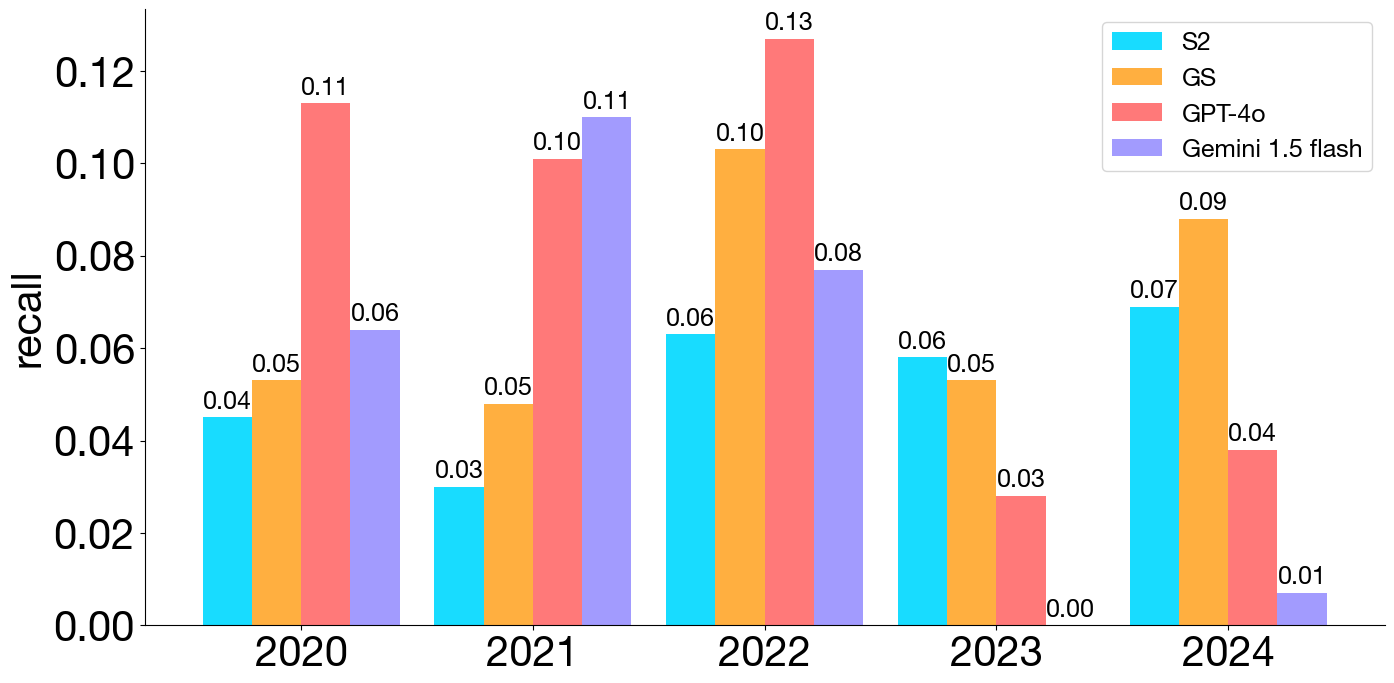

In [6]:
display_evolution_metric(table_years, ["S2","GS", "GPT-4o", "Gemini 1.5 flash"], "recall")